# Домашнее задание 7: Facial landmarks

**Описание/Пошаговая инструкция выполнения домашнего задания:**
- Выберите Facial Detector по вкусу.
- Выполните Face Alignment.
- На это натравите Facial Landmarks Detector по выбору.
- На этом обучите классификатор на предпочитаемом датасете.

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, TQDMProgressBar
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from IPython.display import Image

from emotions_lib import FaceDetector, FaceEmotionsDataMining, FaceEmotionsDataModule
from emotions_lib import FaceEmotionsFCModel, FaceEmotionsTransferModel, FaceEmotionsLandmarksModel

SEED = 2022

## 1 Постановка задачи
### 1.1 Краткие вводные данные

В данной работе будут проведены эксперименты по определению эмоций человека по фотографии.

Краткий алгоритм работы:
- загружаем фото с людьми;
- детектируем лица анфас;
- выравниваем изображение лица с помощью face landmarks;
- формируем признаки для классификационной модели;
- предсказываем эмоцию человека.

## 1.2 Face detection, face aligment и face landmarks

В качестве детектора будем использовать фронтальный детектор лиц из библиотеки dlib. Ограничение - может детектировать только лица с видом спереди. По результатам детекции с помощью библиотеки dlib найдем 5 основных ландмарок (глаза, рот, нос) и с помощью них выполним выравнивание лица. А также с помощью dlib найдем 68 лицевых ориентиров, которые можно использовать для обучения классификационной модели.

Для выполнения этой задачи был сделан класс FaceDetector. С помощью метода detect экземпляра класса FaceDetector можно получить все изображения лиц на фотографии, сделать их выравнивание и получить координаты лицевых ориентиров.

Продемонстрируем работу детектора. Загрузим изображение разозленного мужчины:

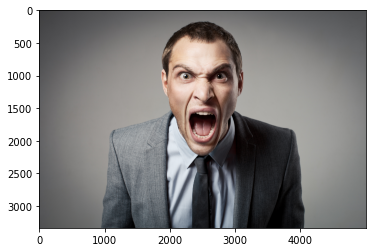

In [2]:
angry_man_image_path = 'temp/angry_man.jpg'
angry_man_img = cv2.imread(angry_man_image_path)
angry_man_img = cv2.cvtColor(angry_man_img, cv2.COLOR_BGR2RGB)
plt.imshow(angry_man_img)
plt.show()

А также изображение счастливого мужчины:

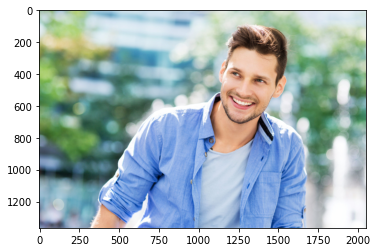

In [3]:
happy_man_image_path = 'temp/happy_man.jpg'
happy_man_img = cv2.imread(happy_man_image_path)
happy_man_img = cv2.cvtColor(happy_man_img, cv2.COLOR_BGR2RGB)
plt.imshow(happy_man_img)
plt.show()

Теперь найдем лицо злого мужчины, выравняем его и получим лицевые ориентиры:

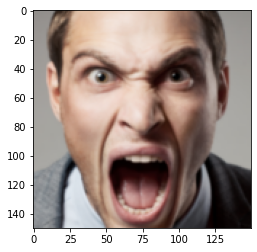

In [4]:
# Инициализация детектора
face_detector = FaceDetector()

angry_man_face_images, angry_man_landmarks = face_detector.detect(angry_man_img, landmarks=True, align=True)
plt.imshow(angry_man_face_images[0])
plt.show()

Визуализируем найденные лицевые ориентиры. Синей точкой будет показан центроид кластера лицевых ориентиров.

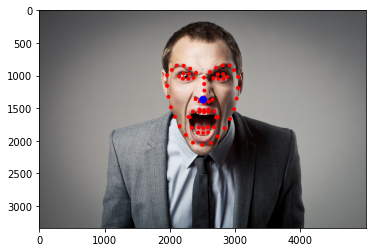

In [5]:
face_detector.visualise_landmarks(angry_man_img, angry_man_landmarks)

Аналогичную операцию выполним для счастливого мужчины:

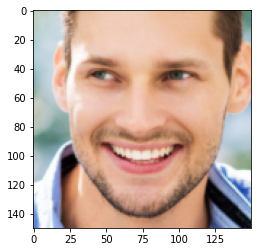

In [6]:
happy_man_face_images, happy_man_landmarks = face_detector.detect(happy_man_img, landmarks=True, align=True)
plt.imshow(happy_man_face_images[0])
plt.show()

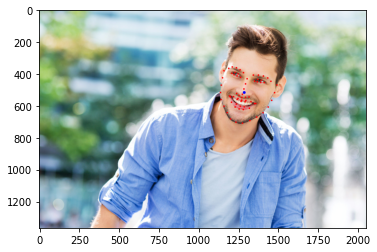

In [7]:
face_detector.visualise_landmarks(happy_man_img, happy_man_landmarks)

Далее лица этих двух людей будем использовать для визуализации результатов работы наших моделей.

# 2 Обучение модели для классификации
### 2.1 Формирования признаков 
#### 2.1.1 Формирование признаков с помощью координат лицевых ориентиров

Данный способ был получен из статьи Facial Expression Recognition using Facial Landmark Detection and Feature Extraction via Neural Network по адресу https://arxiv.org/pdf/1812.04510.pdf

Для обучения модели классификации можно вычислить признаки на основе координат лицевых ориентиров. Можно взять ландмарки для каждой группы лица (рот, правый глаз, левый глаз и др.) и посчитать расстояния между всеми комбинациями точек лицевой группы. А также согласно статье требуется найти центроид лицевых ландмарок и измерить Евклидово расстояние от каждого лицевого ориентира из лицевой группы до центроида.

По данной методике мы получаем 262 признака. При этом некоторые признаки могут быть малоинформативными, но с этим должна разобраться сама нейронная сеть.

Лицевые ориентиры будем получать с помощью библиотеки dlib. На рисунке ниже представлена схема лицевых ориентиров для 68 точек.

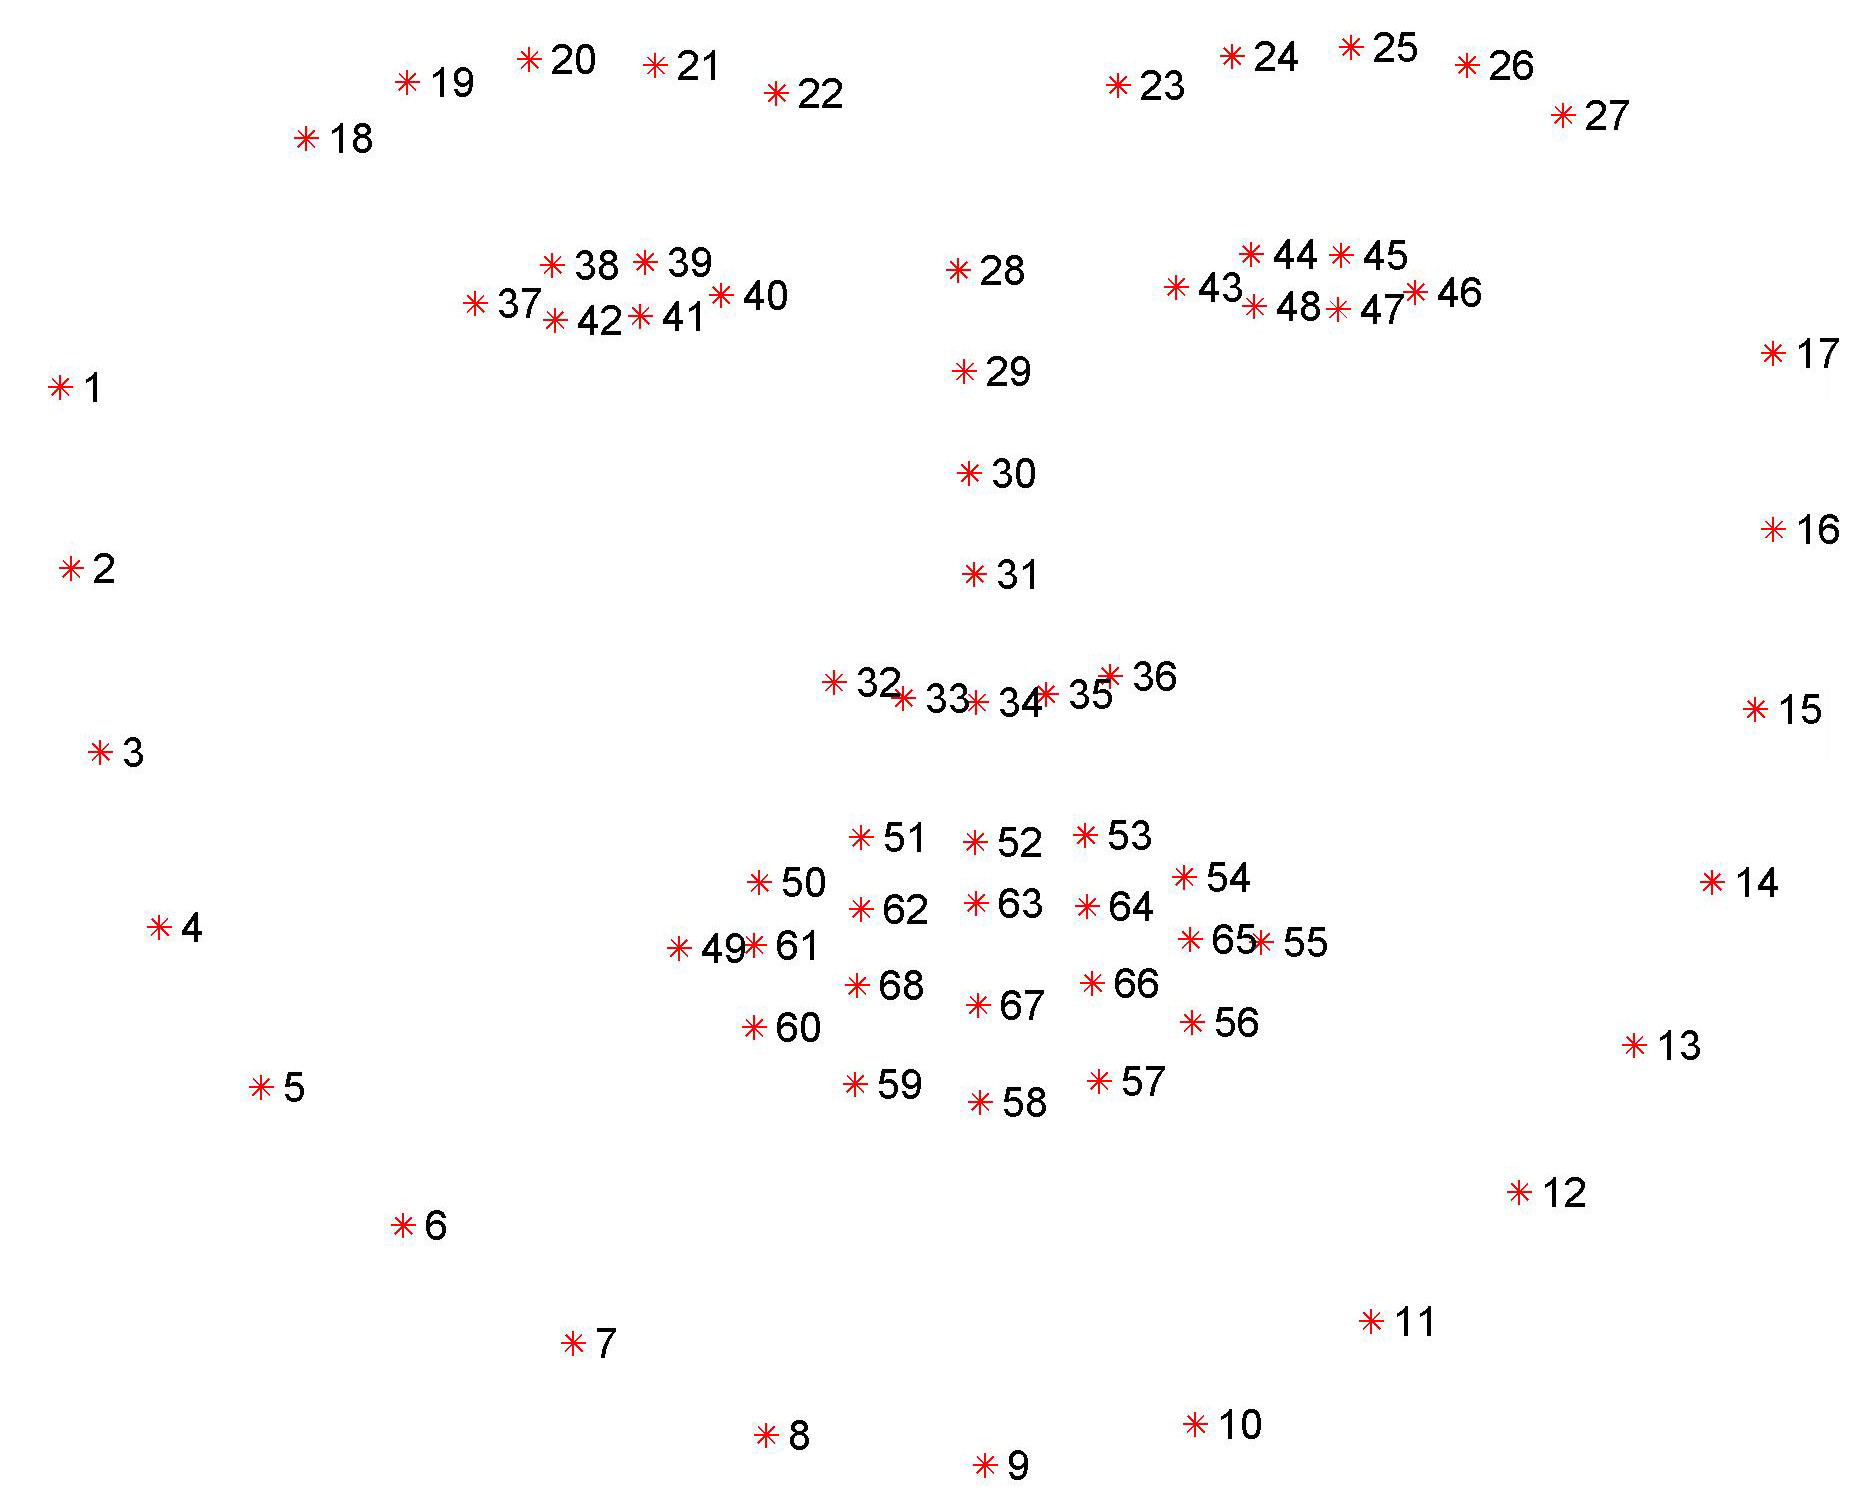

In [8]:
Image("temp/dlib_68_landmarks.jpg", width=450)

Для формирования признаков будем брать следующие группы:
- левая бровь (18-22)
- правая бровь (23-27)
- левый глаз (37-42)
- правый глаз (43-48)
- рот (49-68)

Для извлечения признаков у экземпляра класса FaceDetector есть метод calculate_landmarks_features.

С какими проблемами мы столкнемся при формировании признаков на основе лицевых ориентиров:
- разные масштабы самих изображений
- разные масштабы лиц на изображении

В случае раных масштабов изображений мы можем столкнуться с тем, что одно и то же лицо на изображении разных размеров получит Евклидовы расстояния лицевых ориентиров разных размеров. Эту проблему можно решить с помощью стандартизации. При формировании признаков мы будем учитывать размер изображения, с которого взято лицо. И поделим координаты лицевых ориентиров на размеры изображения. Получим значения от 0 до 1.

Но может быть такая ситуация, что при одинаковом размере изображений на каждом фото будет один и тот же человек с одинаковой эмоцией, но на разном расстоянии. Эту проблему частично можно решить с помощью подгонки изображения лица под фиксированный размер и получения ландмарок уже на выровненном и подогнанном изображении лица. Для обучения моделей будем использовать датасет с изображением лиц размера 48x48, поэтому для корректного предсказания эмоций наших образцов, будем изменять их изображения лиц до данного размера.

Получим признаки с помощью указанного метода с визуализацией группы выбранных ориентиров:

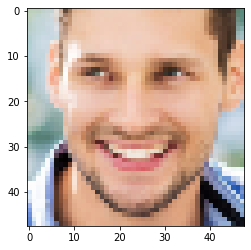

In [9]:
happy_man_face_image_f = cv2.resize(happy_man_face_images[0], (48, 48))
plt.imshow(happy_man_face_image_f)

Сформируем признаки на основе ландмарок. Мы повторно детектируем лицо на выровненном изображении и получаем только лицевые ориентиры. Для стандартизации координат ландмарок передаем размер изображения лица.

In [10]:
_, happy_man_landmarks = face_detector.detect(happy_man_face_image_f, landmarks=True, align=False)
happy_man_result_features = face_detector.calculate_landmarks_features(happy_man_landmarks, 
                                                                       image_size=happy_man_face_image_f.shape)

Аналогичную операцию сделаем для злого человека:

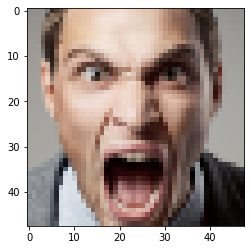

In [11]:
angry_man_face_image_f = cv2.resize(angry_man_face_images[0], (48, 48))
plt.imshow(angry_man_face_image_f)

In [12]:
_, angry_man_landmarks = face_detector.detect(angry_man_face_image_f, landmarks=True, align=False)
angry_man_result_features = face_detector.calculate_landmarks_features(angry_man_landmarks, 
                                                                       image_size=angry_man_face_image_f.shape)

Таким образом мы можем для всех изображений лиц сформировать признаки и обучить модель при условии, что изображения лиц были размечены.

#### 2.1.2 Формирование признаков  с помощью данных изображения

Это более классический метод, просто берем датасет из размеченных изображений лиц, признаки получаем из нейронной сети с CNN-слоями или с помощью трансформера. А выход экстрактора признаков подаем на полносвязную сеть, размер последнего слоя которой равна количеству эмоций в датасете.

#### 2.1.3 Комбинированные признаки

Этот подход такой же, как и метод из 1.3.1.2, но к выходу экстрактора признаков изображения можно добавить признаки ландмарок из пункта 1.3.1.1. И данную комбинацию подать на полносвязный слой.

Ниже представлена схема работы такой модели.

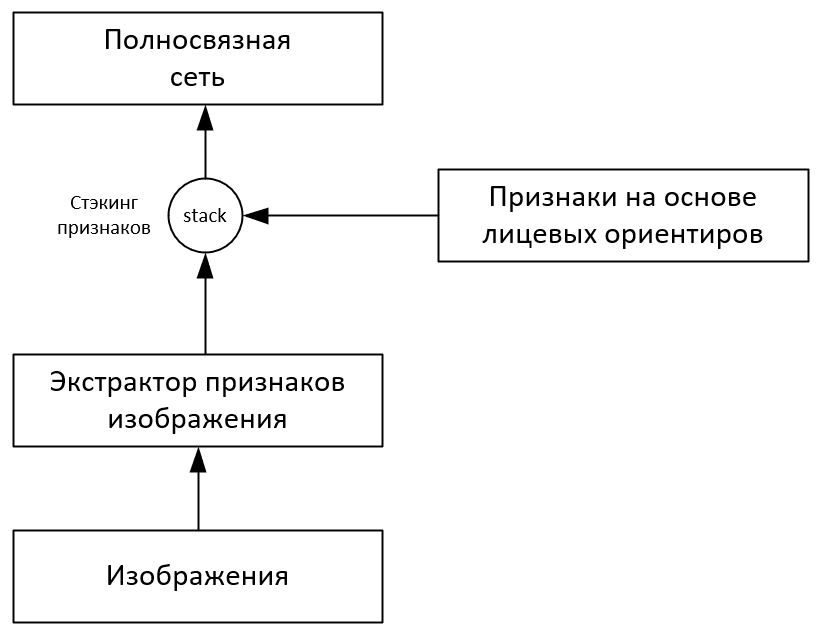

In [13]:
Image("temp/hybrid_model.jpg", width=600)

### 2.2 Датасет для обучения

В качестве датасета для обучения модели был выбран датасет Face expression recognition dataset из соревнования Kaggle:

https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

Он содержит около 30 тысяч изображений лиц, размеченных по 7 видам эмоций. Каждое изображение имеет размер 48x48. При этом все изображения одноканальные и не сильно хорошего качества. Это один из самых доступных датасетов, который можно загрузить без запросов.

Для подготовки данных для обучения любых типов моделей создан класс FaceEmotionsDataMining. С помощью него можно создать датафрейм, в котором будут следующие данные:

- image_path - Путь к изображению
- split - тип разделения фотографии, test или val
- target - целевая метка эмоции человека на изображении
- emoji_name - название эмоции
- f_0 ... f_261 - признаки на основе ландмарок (если лицо на изображении не удалось задетектить, то все признаки будут равны -1)

In [14]:
# Для получения признаков с нуля требуется убрать комментарии кода

# train_images_filepath = "face_expression_recognition_dataset/train/"
# val_images_filepath = "face_expression_recognition_dataset/validation/"
# data_miner = FaceEmotionsDataMining(train_images_filepath=train_images_filepath, val_images_filepath=val_images_filepath)
# data_miner.start()
# emoji_df = data_miner.emoji_df_
# emoji_df.to_excel('emoji_faces.xlsx', index=False)

# Загружаем ранее сформированный датафрейм
emoji_df = pd.read_excel('emoji_faces.xlsx')
emoji_df[:10]

,image_path,split,target,emoji_name,f_0,f_1,f_2,f_3,f_4,f_5,...,f_252,f_253,f_254,f_255,f_256,f_257,f_258,f_259,f_260,f_261
0,face_expression_recognition_dataset/train/angr...,train,0,angry,0.083333,0.171796,0.257694,0.343592,0.093169,0.178000,...,0.987772,0.941427,0.894864,0.943269,0.954021,0.976503,0.993905,0.993905,0.971825,0.961273
1,face_expression_recognition_dataset/train/angr...,train,0,angry,0.085898,0.151669,0.230112,0.318689,0.065881,0.145833,...,0.987772,0.960369,0.905471,0.904512,0.936342,0.959239,1.034979,0.993905,0.971825,0.941196
2,face_expression_recognition_dataset/train/angr...,train,0,angry,0.104167,0.188654,0.298288,0.398020,0.085898,0.197642,...,1.006920,0.963302,0.890000,0.922801,0.943269,0.976503,1.070841,1.011436,0.979388,0.959691
3,face_expression_recognition_dataset/train/angr...,train,0,angry,0.062500,0.147314,0.212459,0.335927,0.085898,0.151669,...,0.987992,0.924681,0.867277,0.850347,0.861251,0.884129,0.971155,0.971825,0.969366,0.931695
4,face_expression_recognition_dataset/train/angr...,train,0,angry,0.065881,0.131762,0.205185,0.380173,0.065881,0.139754,...,1.053475,0.971155,0.839819,0.868278,0.901388,0.937500,1.019131,1.057792,1.044164,0.996957
5,face_expression_recognition_dataset/train/angr...,train,0,angry,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
6,face_expression_recognition_dataset/train/angr...,train,0,angry,0.062500,0.126724,0.197642,0.356609,0.065881,0.139754,...,1.006274,0.960369,0.913821,0.904512,0.925385,0.959239,1.025076,1.011436,0.989748,0.969366
7,face_expression_recognition_dataset/train/angr...,train,0,angry,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
8,face_expression_recognition_dataset/train/angr...,train,0,angry,0.085898,0.167964,0.229167,0.333333,0.083333,0.147314,...,0.987772,0.941427,0.875992,0.850347,0.872516,0.896076,0.979388,0.982706,0.971825,0.951059
9,face_expression_recognition_dataset/train/angr...,train,0,angry,0.075116,0.151669,0.209372,0.294628,0.083333,0.147314,...,0.858980,0.843686,0.817028,0.812500,0.820738,0.838525,0.878959,0.838525,0.829418,0.812500


Сформируем словарь соответствия кодов эмоций их названиям:

In [15]:
uniq_emoji = emoji_df.loc[:, ['target', 'emoji_name']].drop_duplicates().to_numpy()
emoji_target2name = {key: value for (key, value) in uniq_emoji}
emoji_target2name

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

Проверим сколько лиц нам не удалось обнаружить детектором:

In [16]:
print('Всего лиц в датасете:', len(emoji_df))
print('Не удалось задетектить:', len(emoji_df[emoji_df.f_2 < 0]))

Всего лиц в датасете: 35887
Не удалось задетектить: 10928


Не удалось определить около 1/3 лиц. Посмотрим на эти изображенния:

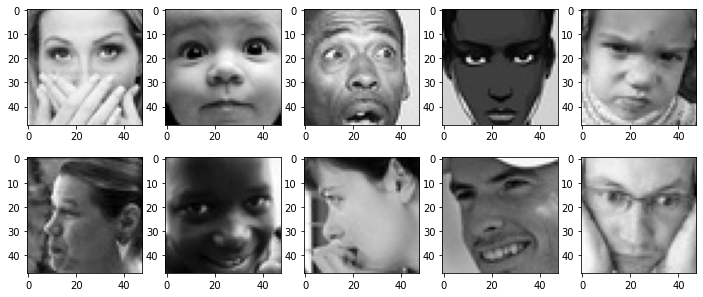

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for idx, (_, row) in enumerate(emoji_df[emoji_df.f_2 < 0].sample(10).iterrows()):
    img = cv2.imread(row.image_path, cv2.IMREAD_GRAYSCALE)
    axes[idx].imshow(img, cmap='gray')
plt.show()

Как видим, это не совсем стандартные изображения. Либо вид лица сбоку, либо закрыто руками, либо детское лицо. Тем не менее для обучения нам доступны 25 тысяч изображений. Поэтому наложим на нашу модель ограничение - она может предсказывать лица только с видом спереди и если оно полностью открыто. А также не сможет определять детские эмоции.

Посмотрим размеры валидационной и обучающей частей:

In [18]:
print('Тренировочный набор:', len(  emoji_df[ (emoji_df.f_2 > 0) & (emoji_df.split == 'train') ]) )
print('Валидационный набор:', len(  emoji_df[ (emoji_df.f_2 > 0) & (emoji_df.split == 'val') ]) )

Тренировочный набор: 19984
Валидационный набор: 4975


Теперь имея сформированные данные мы можем обучить любую модель как на фотографиях, так и только на признаках лицевых ориентиров.

### 2.3 Обучение моделей
#### 2.3.1 Обучение модели RandomForestClassifier

In [19]:
rforest_model = RandomForestClassifier(n_estimators=400, random_state=SEED)

# Берем только те фото, которые удалось задетектировать и найти ориентиры лиц
X = emoji_df[emoji_df.f_1 >= 0]

X_train = X[X.split=='train'].iloc[:, 4:]
y_train = X[X.split=='train'].iloc[:, 2]

X_val = X[X.split=='val'].iloc[:, 4:]
y_val = X[X.split=='val'].iloc[:, 2]

In [20]:
rforest_model.fit(X_train, y_train)
y_pred = rforest_model.predict(X_val)

In [21]:
print('accuracy score:', accuracy_score(y_pred, y_val))

accuracy score: 0.5708542713567839


Получили Accuracy Score 0.567. Рассмотрим матрицу ошибок.

In [22]:
def print_confusion_matrix(cf_matrix, target_names):
    
    plt.figure(figsize=(14,7))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(target_names)
    ax.yaxis.set_ticklabels(target_names)

    plt.show()

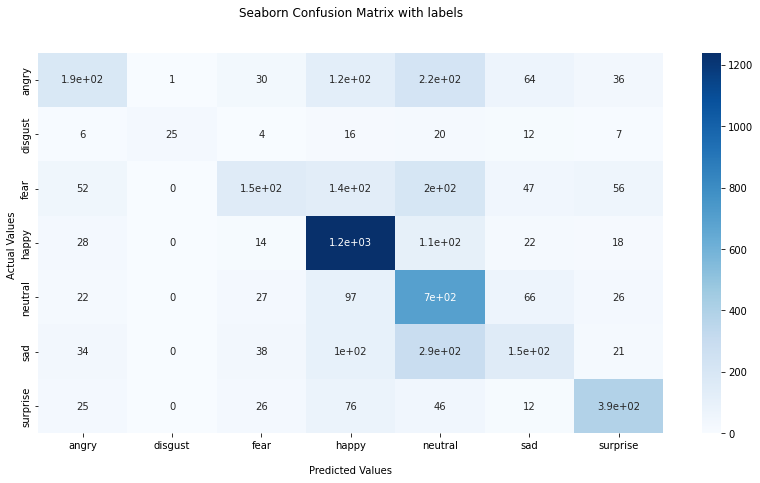

In [23]:
cf_matrix = confusion_matrix(y_val, y_pred)
print_confusion_matrix(cf_matrix, target_names=emoji_target2name.values())

Из матрицы ошибок видно, что злость больше всего можем перепутать со счастливым и нейтральным выражением лица. А счастливое лицо больше всго можем перепутать с нейтральным.

Определим ТОП-3 эмоций для наших тестовых изображений:

1. happy
2. fear
3. surprise


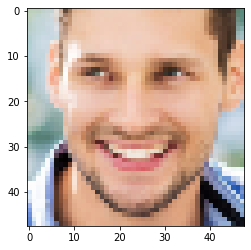

In [24]:
test_image_predict = rforest_model.predict_proba(happy_man_result_features)
for idx, emoji_code in enumerate(np.argsort(test_image_predict)[0][::-1], 1):
    print(f"{idx}. {emoji_target2name[emoji_code]}")
    if idx == 3:
        break
plt.imshow(happy_man_face_image_f)
plt.show()

1. surprise
2. angry
3. fear


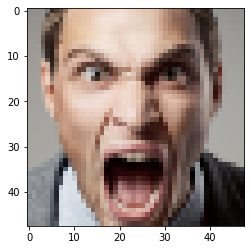

In [25]:
test_image_predict = rforest_model.predict_proba(angry_man_result_features)
for idx, emoji_code in enumerate(np.argsort(test_image_predict)[0][::-1], 1):
    print(f"{idx}. {emoji_target2name[emoji_code]}")
    if idx == 3:
        break
plt.imshow(angry_man_face_image_f)
plt.show()

Не смотря на недостаточную точность модели, эмоции тестовых изображений были определены верно.

#### 2.3.2 Обучение полносвязной нейронной сети на признаках лицевых ориентиров

Для обучения полносвязной сети создан класс FaceEmotionsFCModel. Данная модель состоит из 4 полносвязных слоев, размером 1024. Выход сети равняется 7. А вход - количеству признаков лицевых ориентиров.

С помощью параметра only_detected_landmarks оставляем для обучения только те изображения, которые мы смогли обнаружить и получить лицевые ориентиры.

In [26]:
config_model = {'seed': SEED,
    'model': {
        'plot_epoch_loss': True,
        'dropout': 0.5,
        'learning_rate': 0.00005, 
        'l2_regularization': 0.01,
        'adam_betas': (0.99, 0.999),
        'seed': SEED,
    },
    'trainer': {
        'max_epochs': 300,
        'gpus': 1 if torch.cuda.is_available() else 0,
        'resume_from_checkpoint': None,
    },
    'datamodule': {
        'seed': SEED,
        'emoji_faces_df': emoji_df,
        'train_loader_params': {
            'batch_size': 64,
            'shuffle': True,
            'num_workers': 0,
            'pin_memory': False,
            'drop_last': True,
        },
        'val_loader_params': {
            'batch_size': 64,
            'shuffle': False,
            'num_workers': 0,
            'pin_memory': False,
            'drop_last': False
        },
        'dataset_params': {
            'only_landmark_features': True, 
            'only_detected_landmarks': True,
            'std_for_add_features': True,
        },    
    },
}

In [27]:
fc_model = FaceEmotionsFCModel(**config_model['model'])

face_emotions_datamodule = FaceEmotionsDataModule(**config_model['datamodule'])

checkpoint = ModelCheckpoint(dirpath='checkpoint_fc_model/', monitor='val_accuracy', mode='max')

callbacks = [
            EarlyStopping('val_accuracy', min_delta=0.001, patience=5, mode='max'),
            TQDMProgressBar(refresh_rate=10),
            checkpoint
]

trainer = pl.Trainer(**config_model['trainer'], callbacks=callbacks)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


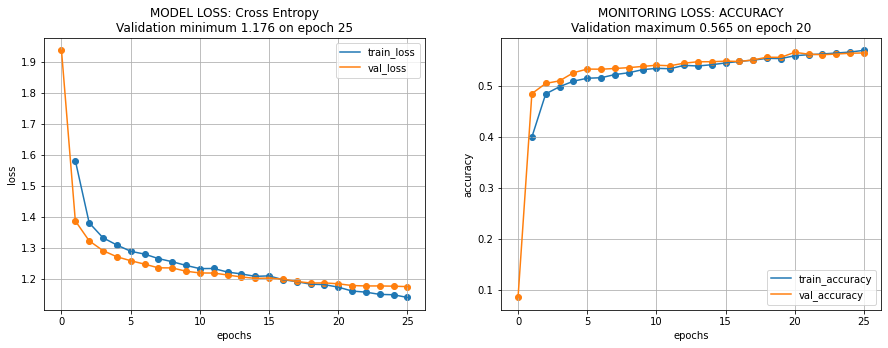

In [28]:
trainer.fit(fc_model, face_emotions_datamodule)

Загружаем веса модели с наилучшим accuracy:

In [29]:
fc_model = FaceEmotionsFCModel.load_from_checkpoint(checkpoint.best_model_path)

Построим матрицу ошибок на валидационной части датасета:

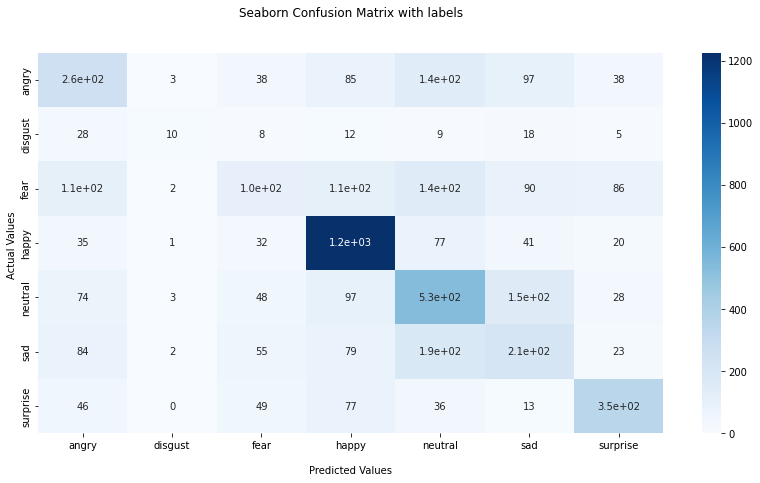

In [30]:
y_pred = []
y_val = []

for batch in face_emotions_datamodule.val_dataloader():
    predict = np.argmax(fc_model(batch['landmark_features']).detach().cpu().numpy(), axis=1).flatten()
    y_pred.append(predict)
    y_val.append(batch['target'].cpu().numpy())
    
y_pred = np.hstack(y_pred)
y_val = np.hstack(y_val)

cf_matrix = confusion_matrix(y_val, y_pred)
print_confusion_matrix(cf_matrix, target_names=emoji_target2name.values())

Из матрицы видно, что в этой модели мы стали меньше путать счастливые лица со злыми, но все еще сильно путаем их с нейтральными. А также мы не можем нормально предсказать выражения страха, часто путаем их почти со всему другими эмоциями. А также плохо отличаем друг от друга нейтральное выражение лица и грустное.

Проверим предсказания модели на наших образцах:

1. fear
2. angry
3. sad


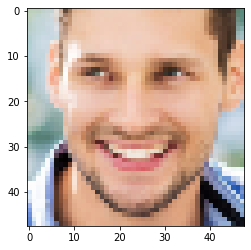

In [31]:
test_image_predict = fc_model(torch.tensor(happy_man_result_features, dtype=torch.float32)).detach().cpu().numpy()

for idx, emoji_code in enumerate(np.argsort(test_image_predict)[0][::-1], 1):
    print(f"{idx}. {emoji_target2name[emoji_code]}")
    if idx == 3:
        break
        
plt.imshow(happy_man_face_image_f)
plt.show()

1. fear
2. angry
3. surprise


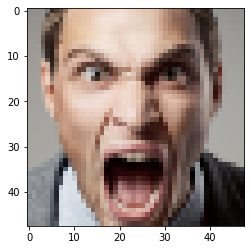

In [32]:
test_image_predict = fc_model(torch.tensor(angry_man_result_features, dtype=torch.float32)).detach().cpu().numpy()

for idx, emoji_code in enumerate(np.argsort(test_image_predict)[0][::-1], 1):
    print(f"{idx}. {emoji_target2name[emoji_code]}")
    if idx == 3:
        break
plt.imshow(angry_man_face_image_f)
plt.show()

Результаты можно назвать плохими, в обоих модель предсказала страх. А для счастливого человека его корректная эмоция не вошла даже в тройку.

#### 2.3.3 Обучение модели EfficientNet с помощью выделения признаков из изображений

Для обучения такого типа сети создан класс FaceEmotionsTransferModel. Классическая структура, выделяем признаки непосредственно из изображений с помощью сверточных слоев и подаем выход на полносвязную сеть с выходом размера количества эмоций.

С помощью параметра output_dims задаем структуру слоев полносвязной сети на выходе экстрактора признаков.

In [33]:
config_model = {'seed': SEED,
    'model': {
        'model_name': 'efficientnetv2_b3',
        'output_dims': [256, 128, 7],
        'plot_epoch_loss': True,
        'dropout': 0.5,
        'learning_rate': 0.00005, 
        'l2_regularization': 0.01,
        'adam_betas': (0.99, 0.999),
        'full_trainable': True,
        'pretrained': True,
        'seed': SEED,
    },
    'trainer': {
        'max_epochs': 300,
        'gpus': 1 if torch.cuda.is_available() else 0,
        'resume_from_checkpoint': None,
    },
    'datamodule': {
        'seed': SEED,
        'emoji_faces_df': emoji_df,
        'train_loader_params': {
            'batch_size': 64,
            'shuffle': True,
            'num_workers': 0,
            'pin_memory': False,
            'drop_last': True,
        },
        'val_loader_params': {
            'batch_size': 64,
            'shuffle': False,
            'num_workers': 0,
            'pin_memory': False,
            'drop_last': False
        },
        'dataset_params': {
            'image_size': 224,
            'only_landmark_features': False, 
            'only_detected_landmarks': True,
            'std_for_add_features': False,
        },    
    },
}

In [34]:
eff_model = FaceEmotionsTransferModel(**config_model['model'])

face_emotions_datamodule = FaceEmotionsDataModule(**config_model['datamodule'])

checkpoint = ModelCheckpoint(dirpath='checkpoint_eff_model/', monitor='val_accuracy', mode='max')

callbacks = [
            EarlyStopping('val_accuracy', min_delta=0.001, patience=3, mode='max'),
            TQDMProgressBar(refresh_rate=10),
            checkpoint
]

trainer = pl.Trainer(**config_model['trainer'], callbacks=callbacks)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


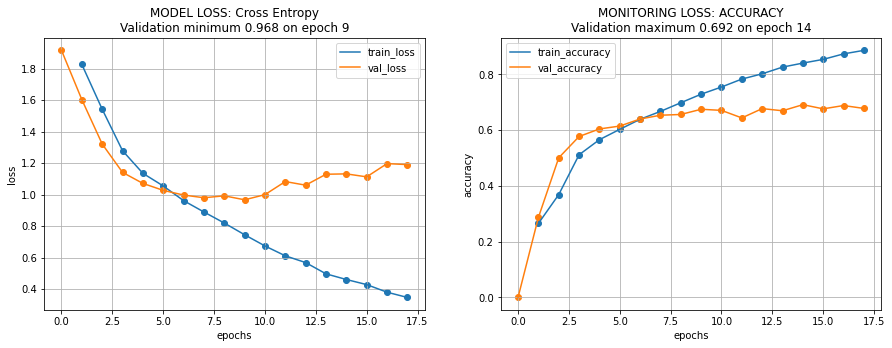

In [35]:
trainer.fit(eff_model, face_emotions_datamodule)

Модель обучилась значительно лучше предыдущей модели.

Загружаем веса модели с наилучшим accuracy:

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eff_model = FaceEmotionsTransferModel.load_from_checkpoint(checkpoint.best_model_path)
eff_model = eff_model.to(device)

Построим матрицу ошибок на валидационной части датасета:

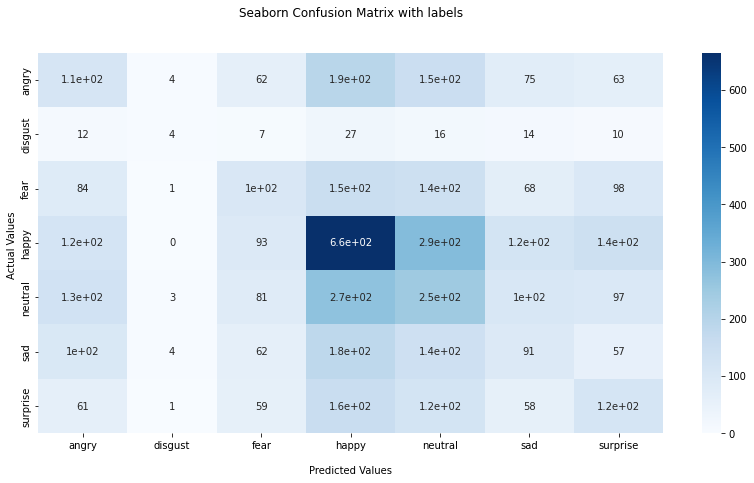

In [37]:
y_pred = []
y_val = []

for batch in face_emotions_datamodule.val_dataloader():
    predict = np.argmax(eff_model(batch['x_data'].to(device)).detach().cpu().numpy(), axis=1).flatten()
    y_pred.append(predict)
    y_val.append(batch['target'].cpu().numpy())
    
y_pred = np.hstack(y_pred)
y_val = np.hstack(y_val)

cf_matrix = confusion_matrix(y_val, y_pred)
print_confusion_matrix(cf_matrix, target_names=emoji_target2name.values())

Несмотря на то, что модель обучилась лучше, по матрице ошибок результаты далеки от хороших.

Теперь мы сильно путаем счастливые лица не только с нейтральными, но и с грустными, удивленными и злыми. А также почти все эмоции можем сильно перепутать со счастьем и нейтральным настроением.

Проверим предсказания модели на наших образцах. Чтобы наше изображение было максимально похоже на изображение входа сети из нашего датасета, мы делаем следующие операции:

- конвертируем изображение лица размера 48x48 в Grayscale
- конвертируем из Grayscale в RGB
- увеличиваем размер итогового изображения до 224x224

In [38]:
def image_prepare(img, face_emotions_datamodule):
    img = np.copy(img)
    img = cv2.cvtColor(happy_man_face_image_f, cv2.COLOR_RGB2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = cv2.resize(img, (224,224))
    img = torch.tensor(img).permute(2,0,1)
    img = face_emotions_datamodule.val_dataset._target_transforms(img)
    img = img.view(1, img.shape[0], img.shape[1], img.shape[2])
    
    return img

1. happy
2. neutral
3. surprise


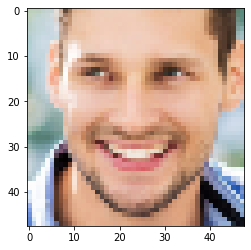

In [39]:
img = image_prepare(happy_man_face_image_f, face_emotions_datamodule)

test_image_predict = eff_model(img.to(device)).detach().cpu().numpy()
for idx, emoji_code in enumerate(np.argsort(test_image_predict)[::-1], 1):
    print(f"{idx}. {emoji_target2name[emoji_code]}")
    if idx == 3:
        break
        
plt.imshow(happy_man_face_image_f)
plt.show()

1. happy
2. neutral
3. angry


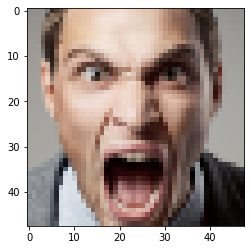

In [40]:
img = image_prepare(angry_man_face_image_f, face_emotions_datamodule)

test_image_predict = eff_model(img.to(device)).detach().cpu().numpy()

for idx, emoji_code in enumerate(np.argsort(test_image_predict)[::-1], 1):
    print(f"{idx}. {emoji_target2name[emoji_code]}")
    if idx == 3:
        break

plt.imshow(angry_man_face_image_f)
plt.show()

Именно эти эмоции наша модель больше всего путает. В случае счастливого человека модель угадала эмоцию, а для злого его эмоция вошла только в тройку.

#### 2.3.3 Обучение комбинированной модели EfficientNet (изображения + признаки лицевых ориентиров)

Для обучения такого типа сети создан класс FaceEmotionsLandmarksModel. Выделяем признаки непосредственно из изображений с помощью сверточных слоев, добавляем к выходу экстрактора признаков фичи ландмарок и подаем данную комбинацию на полносвязную сеть с выходом размера количества эмоций.

In [41]:
config_model = {'seed': SEED,
    'model': {
        'model_name': 'efficientnetv2_b3',
        'output_dims': [256, 128, 7],
        'plot_epoch_loss': True,
        'dropout': 0.5,
        'learning_rate': 0.00005, 
        'l2_regularization': 0.01,
        'adam_betas': (0.99, 0.999),
        'full_trainable': True,
        'pretrained': True,
        'seed': SEED,
    },
    'trainer': {
        'max_epochs': 300,
        'gpus': 1 if torch.cuda.is_available() else 0,
        'resume_from_checkpoint': None,
    },
    'datamodule': {
        'seed': SEED,
        'emoji_faces_df': emoji_df,
        'train_loader_params': {
            'batch_size': 64,
            'shuffle': True,
            'num_workers': 0,
            'pin_memory': False,
            'drop_last': True,
        },
        'val_loader_params': {
            'batch_size': 64,
            'shuffle': False,
            'num_workers': 0,
            'pin_memory': False,
            'drop_last': False
        },
        'dataset_params': {
            'image_size': 224,
            'only_landmark_features': False, 
            'only_detected_landmarks': True,
            'std_for_add_features': False,
        },    
    },
}

In [42]:
eff_hybrid_model = FaceEmotionsLandmarksModel(**config_model['model'])

face_emotions_datamodule = FaceEmotionsDataModule(**config_model['datamodule'])

checkpoint = ModelCheckpoint(dirpath='checkpoint_hybrid_model/', monitor='val_accuracy', mode='max')

callbacks = [
            EarlyStopping('val_accuracy', min_delta=0.001, patience=3, mode='max'),
            TQDMProgressBar(refresh_rate=10),
            checkpoint
]

trainer = pl.Trainer(**config_model['trainer'], callbacks=callbacks)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


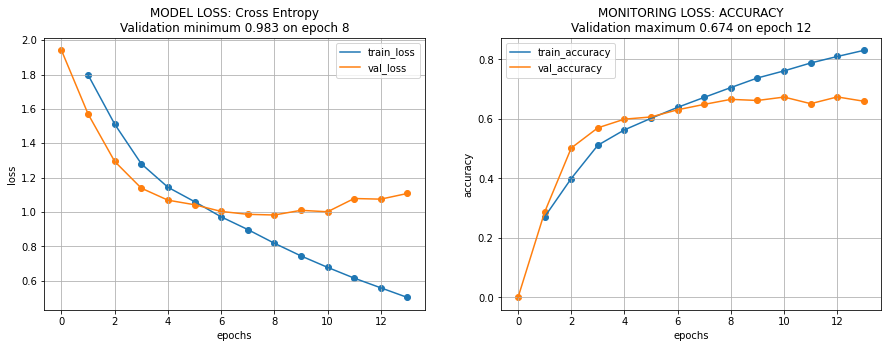

In [43]:
trainer.fit(eff_hybrid_model, face_emotions_datamodule)

Загружаем веса модели с наилучшим accuracy:

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eff_hybrid_model = FaceEmotionsLandmarksModel.load_from_checkpoint(checkpoint.best_model_path)
eff_hybrid_model = eff_hybrid_model.to(device)

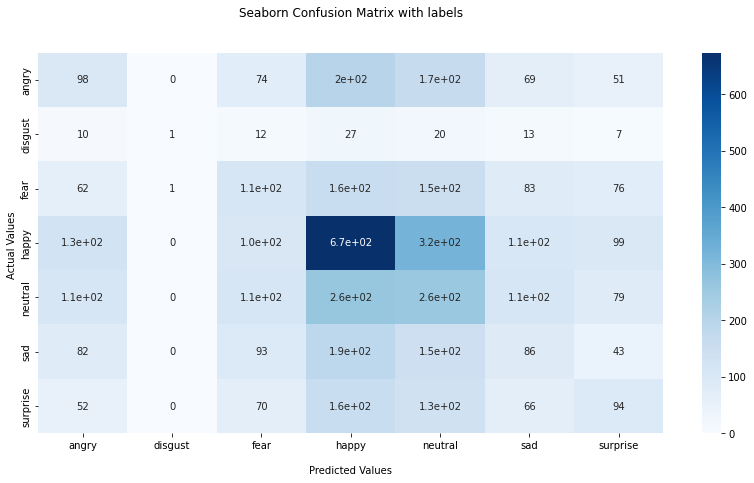

In [45]:
y_pred = []
y_val = []

for batch in face_emotions_datamodule.val_dataloader():
    predict = np.argmax(eff_hybrid_model(batch['x_data'].to(device), 
                                         batch['landmark_features'].to(device)).detach().cpu().numpy(), axis=1).flatten()
    y_pred.append(predict)
    y_val.append(batch['target'].cpu().numpy())
    
y_pred = np.hstack(y_pred)
y_val = np.hstack(y_val)

cf_matrix = confusion_matrix(y_val, y_pred)
print_confusion_matrix(cf_matrix, target_names=emoji_target2name.values())

1. happy
2. neutral
3. surprise


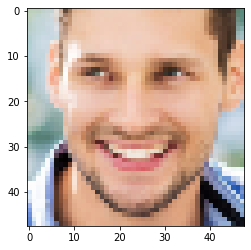

In [46]:
img = image_prepare(happy_man_face_image_f, face_emotions_datamodule)

landmark_features = torch.tensor(happy_man_result_features, dtype=torch.float32).to(device)
test_image_predict = eff_hybrid_model(img.to(device), landmark_features).detach().cpu().numpy()

for idx, emoji_code in enumerate(np.argsort(test_image_predict)[::-1], 1):
    print(f"{idx}. {emoji_target2name[emoji_code]}")
    if idx == 3:
        break
        
plt.imshow(happy_man_face_image_f)
plt.show()

1. happy
2. neutral
3. angry


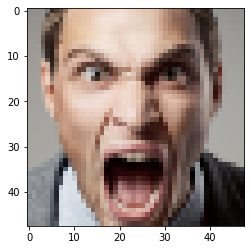

In [47]:
img = image_prepare(angry_man_face_image_f, face_emotions_datamodule)

landmark_features = torch.tensor(angry_man_result_features, dtype=torch.float32).to(device)
test_image_predict = eff_hybrid_model(img.to(device), landmark_features).detach().cpu().numpy()

for idx, emoji_code in enumerate(np.argsort(test_image_predict)[::-1], 1):
    print(f"{idx}. {emoji_target2name[emoji_code]}")
    if idx == 3:
        break
        
plt.imshow(angry_man_face_image_f)
plt.show()

#### 2.3.4 Обучение  модели SwinTransformer на признаках изображений

In [48]:
config_model = {'seed': SEED,
    'model': {
        'model_name': 'swin_tiny_patch4_window7_224',
        'output_dims': [256, 128, 7],
        'plot_epoch_loss': True,
        'dropout': 0.5,
        'learning_rate': 0.00005, 
        'l2_regularization': 0.01,
        'adam_betas': (0.99, 0.999),
        'full_trainable': True,
        'pretrained': True,
        'seed': SEED,
    },
    'trainer': {
        'max_epochs': 300,
        'gpus': 1 if torch.cuda.is_available() else 0,
        'resume_from_checkpoint': None,
    },
    'datamodule': {
        'seed': SEED,
        'emoji_faces_df': emoji_df,
        'train_loader_params': {
            'batch_size': 16,
            'shuffle': True,
            'num_workers': 0,
            'pin_memory': False,
            'drop_last': True,
        },
        'val_loader_params': {
            'batch_size': 16,
            'shuffle': False,
            'num_workers': 0,
            'pin_memory': False,
            'drop_last': False
        },
        'dataset_params': {
            'image_size': 224,
            'only_landmark_features': False, 
            'only_detected_landmarks': True,
            'std_for_add_features': False,
        },    
    },
}

In [49]:
swin_model = FaceEmotionsTransferModel(**config_model['model'])

face_emotions_datamodule = FaceEmotionsDataModule(**config_model['datamodule'])

checkpoint = ModelCheckpoint(dirpath='checkpoint_swin_model/', monitor='val_accuracy', mode='max')

callbacks = [
            EarlyStopping('val_accuracy', min_delta=0.001, patience=5, mode='max'),
            TQDMProgressBar(refresh_rate=10),
            checkpoint
]

trainer = pl.Trainer(**config_model['trainer'], callbacks=callbacks)

/opt/conda/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2311.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


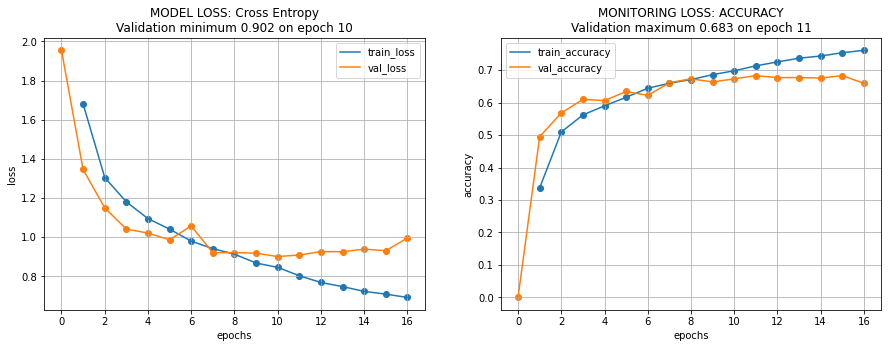

In [50]:
trainer.fit(swin_model, face_emotions_datamodule)

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
swin_model = FaceEmotionsTransferModel.load_from_checkpoint(checkpoint.best_model_path)
swin_model = swin_model.to(device)

Посмотрим матрицу ошибок для трансформера Swin:

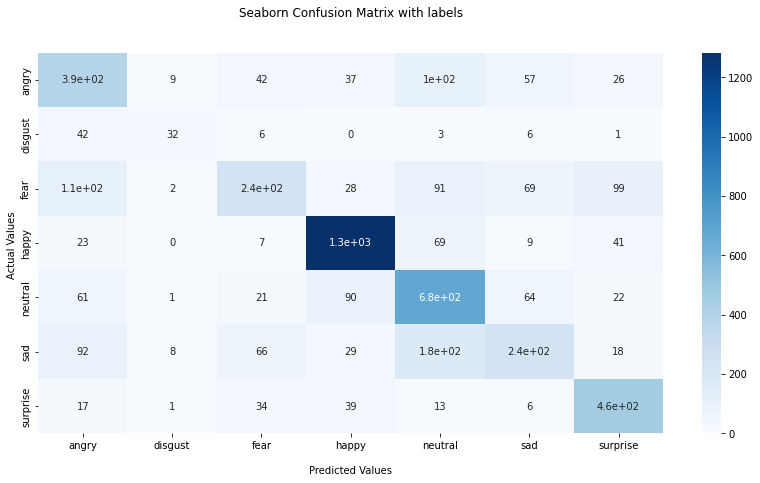

In [52]:
y_pred = []
y_val = []

for batch in face_emotions_datamodule.val_dataloader():
    predict = np.argmax(swin_model(batch['x_data'].to(device)).detach().cpu().numpy(), axis=1).flatten()
    y_pred.append(predict)
    y_val.append(batch['target'].cpu().numpy())
    
y_pred = np.hstack(y_pred)
y_val = np.hstack(y_val)

cf_matrix = confusion_matrix(y_val, y_pred)
print_confusion_matrix(cf_matrix, target_names=emoji_target2name.values())

Не смотря на то, что SWIN-трансформер не одержал победу в оценке accuracy на валидации, у него самая лучшая матрица ошибок. Ошибки между классами есть, но уже в гораздо меньших масштабах. Злость можем перепутать с нейтральным выражением, а страх со злостью. И есть путаница печали с нейтральным выражением.

Проверим как отработает модель на наших образцах:

1. happy
2. neutral
3. surprise


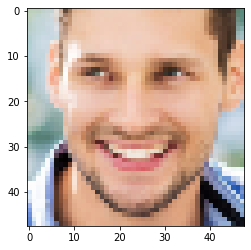

In [53]:
img = image_prepare(happy_man_face_image_f, face_emotions_datamodule)

test_image_predict = swin_model(img.to(device)).detach().cpu().numpy()
for idx, emoji_code in enumerate(np.argsort(test_image_predict)[::-1], 1):
    print(f"{idx}. {emoji_target2name[emoji_code]}")
    if idx == 3:
        break
        
plt.imshow(happy_man_face_image_f)
plt.show()

1. happy
2. neutral
3. sad


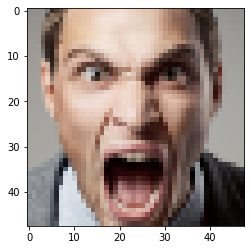

In [54]:
img = image_prepare(angry_man_face_image_f, face_emotions_datamodule)

test_image_predict = swin_model(img.to(device)).detach().cpu().numpy()

for idx, emoji_code in enumerate(np.argsort(test_image_predict)[::-1], 1):
    print(f"{idx}. {emoji_target2name[emoji_code]}")
    if idx == 3:
        break

plt.imshow(angry_man_face_image_f)
plt.show()

Модель не смогла корректно определить злого человека, что не вяжется с таблицей ошибок модели. Это может говорить о том, что наши изображения достаточно сильно отличаются от изображений в датасете. И для решения нашей задачи было бы лучше подобрать другой датасет для обучения.

А теперь посмотрим на результаты предсказаний на валидационном датасете нашей лучшей модели трансформера SWIN:

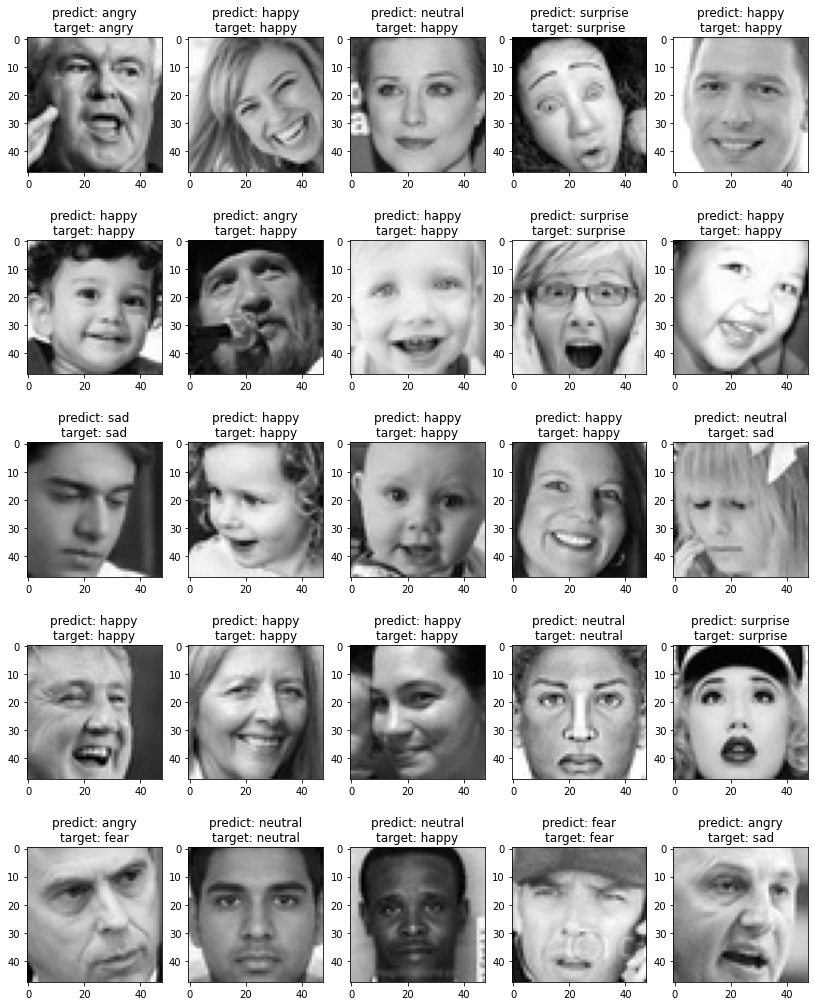

In [55]:
face_emotions_datamodule.val_loader_params['batch_size'] = 1
face_emotions_datamodule.val_loader_params['shuffle'] = True

_, axes = plt.subplots(5,5, figsize=(14,18))
axes = axes.flatten()
val_loader = face_emotions_datamodule.val_dataloader()

for idx, batch in enumerate(val_loader):
    img = cv2.imread(batch['image_path'][0], cv2.IMREAD_GRAYSCALE)
    axes[idx].imshow(img, cmap='gray')
    
    prediction = swin_model(batch['x_data'].to(device)).cpu().detach().numpy().flatten()
    pred_target = emoji_target2name[np.argmax(prediction)]
    true_target = emoji_target2name[batch['target'][0].item()]
    
    axes[idx].set_title(f"predict: {pred_target}\ntarget: {true_target}")
    
    if idx >= 24:
        break

Данные результаты можно назвать хорошими, в целом предсказания эмоций корректные.

# Результаты

В данной работе был проведен эксперимент с обучением различных типов моделей. В таблице приведены сводные результаты эксперимента. В столбце "Матрица ошибок" приведена субъективная оценка качества.


| Модель                     | Набор признаков                           | Accuracy     | Матрица ошибок |
| -------------------------- |:-----------------------------------------:| :-----------:|---------------:|
| RandomForestClassifier     | признаки ландмарок                        | 0.567        | 5 из 10        |
| FC Model                   | признаки ландмарок                        | 0.565        | 4 из 10        |
| EfficientNetB3             | признаки изображения                      | **0.692**    | 4 из 10        |
| EfficientNetB3             | признаки изображения + признаки ландмарок | 0.674        | 4 из 10        |
| SWIN-Transformer           | признаки изображения                      | 0.683        | 6 из 10        |

Из результатов экспериментов можно сделать следующие заключения:
- в рамках эксперимента извлечение признаков изображений было более эффективно, чем извлечение признаков из лицевых ориентиров
- модели научились неплохо определять эмоции на валидационной части датасета, но удовлетворительно справлялись с определением эмоций у изображений вне датасета

Что можно улучшить:
- попробовать более точным образом подогнать сторонние изображения лиц под формат датасета, чтобы получать более точные прогнозы
- взять другой датасет для обучения моделей, который будет лучше подходить по качеству и под наши задачи 